In [41]:
import sys
assert sys.version_info >= (3,5)

In [42]:
import sklearn
assert sklearn.__version__ >= "0.20"

In [43]:
import pandas as pd

In [44]:
import numpy as np

In [45]:
import scipy.stats as stats

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
from pandas.plotting import scatter_matrix

In [48]:
import time

In [49]:
import cv2

In [50]:
import seaborn as sns

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize

In [53]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [54]:
from sklearn.model_selection import cross_val_score

In [55]:
from itertools import cycle

In [56]:
from sklearn.cluster import KMeans

In [57]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [58]:
complete_x_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_train_all.csv')
complete_y_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_train_all.csv')
complete_x_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_test_all.csv')
complete_y_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_test_all.csv')

In [59]:
dim = (48,48)

In [60]:
def process_image(image_path):
    # Read the image in grayscale
    pixel_array = image_path
    reshaped_array = pixel_array.reshape((48, 48)) 
    normalized_array = np.uint8(reshaped_array*255)

    image_eq = cv2.equalizeHist(normalized_array)

    # Convert the image to binary using Otsu's method
    _, binary_image = cv2.threshold(image_eq, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Compute the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the number from the image
    number = normalized_array[y:y+h, x:x+w]

    return [number,h, w]

In [61]:
def img_denoiser(arr): 
    pixel_array = arr
    reshaped_array = pixel_array.reshape((48, 48)) 
    normalized_array = np.uint8(reshaped_array*255)
    if normalized_array.ndim != 2:
        raise ValueError("The image should have 2 dimensions")
    
    # thresholded_image = cv2.resize(normalized_array,dim)
    thresholded_image = cv2.adaptiveThreshold(normalized_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY_INV, 11, 1)
    return thresholded_image





In [62]:
def simplify(arr):
    im = process_image(np.array(arr))
    ret = img_denoiser(cv2.resize(im[0].reshape(im[1],im[2]),(48,48)))
    return ret

In [63]:
complete_x_train_denoise = np.apply_along_axis(
    func1d=lambda img: simplify(img),
    axis=1, arr=complete_x_train.copy()).reshape(-1, dim[0]*dim[1])

complete_x_test_denoise = np.apply_along_axis(
    func1d=lambda img: simplify(img),
    axis=1, arr=complete_x_test.copy()).reshape(-1, dim[0]*dim[1])

complete_x_train_denoise = pd.DataFrame(complete_x_train_denoise)
complete_x_test_denoise = pd.DataFrame(complete_x_test_denoise)

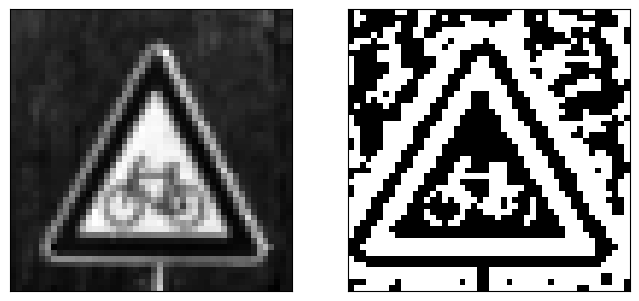

In [64]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(complete_x_train.iloc[9590].to_numpy().reshape(48,48),'gray')
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(complete_x_train_denoise.iloc[9590].to_numpy().reshape(dim),'gray')

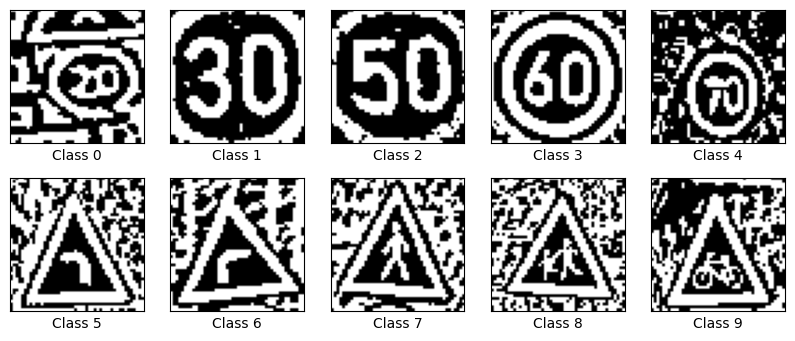

In [65]:
plt.figure(figsize=(10,4))

img_toshow = [0,210,2435,6085,7030,8275,8635,8875,9415,9685]

for i in range (0, len(img_toshow)):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(complete_x_train_denoise.iloc[img_toshow[i]].to_numpy().reshape(dim), cmap='gray')
    plt.xlabel("Class "+str(complete_y_train.iloc[img_toshow[i]].to_numpy()[0]))

In [66]:
joined_dataset = complete_x_train_denoise.copy()
joined_dataset['class']=complete_y_train.copy()

grouped_dataset = joined_dataset.groupby('class', group_keys=False)
avg_val = int(grouped_dataset['class'].value_counts().max())

In [67]:
balanced_dataset = pd.DataFrame()

for i in range(0,10):
        balanced_dataset = pd.concat([balanced_dataset, joined_dataset[joined_dataset['class']==i].sample(avg_val, replace=True)])

balanced_dataset_x = balanced_dataset.iloc[:,:dim[0]*dim[1]]
balanced_dataset_y = balanced_dataset.iloc[:,dim[0]*dim[1]:]

In [68]:
from sklearn.decomposition import PCA

# Calculate all PCA components
pca = PCA()
pca.fit(balanced_dataset_x)

# Calculate the cumulative sum of explained variance ratios
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to explain 95% of variance
n_components_95 = np.where(cumulative_variance > 0.95)[0][0] + 1

print(f"To retain 95% of the variance, use n_components = {n_components_95}")


To retain 95% of the variance, use n_components = 1185


In [69]:
pca = PCA(n_components_95)
X_pca = pca.fit_transform(balanced_dataset_x)
tsne = TSNE(n_components=2, random_state=42).fit_transform(X_pca)

In [70]:
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state = 42, n_init=10)
kmeans.fit(tsne)

KMeans(n_clusters=10, n_init=10, random_state=42)

In [71]:
kmeans_centroids = kmeans.cluster_centers_
kmeans_centroids

array([[  94.50321  ,   44.73546  ],
       [-103.27794  ,  -36.130142 ],
       [  30.21132  ,   -0.9790061],
       [ -45.912277 ,   88.92008  ],
       [  25.282656 ,  -75.73904  ],
       [  90.44151  ,  -38.67701  ],
       [  25.349947 ,   87.79308  ],
       [ -49.257706 ,  -85.83189  ],
       [-101.05718  ,   40.740807 ],
       [ -32.727745 ,    6.0373616]], dtype=float32)

In [72]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

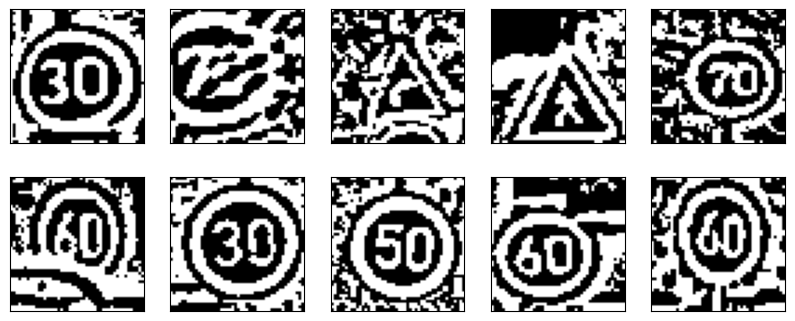

In [73]:
plt.figure(figsize=(10,4))

for i in range (0, 10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(complete_x_test_denoise.iloc[i].to_numpy().reshape(dim), cmap='gray')

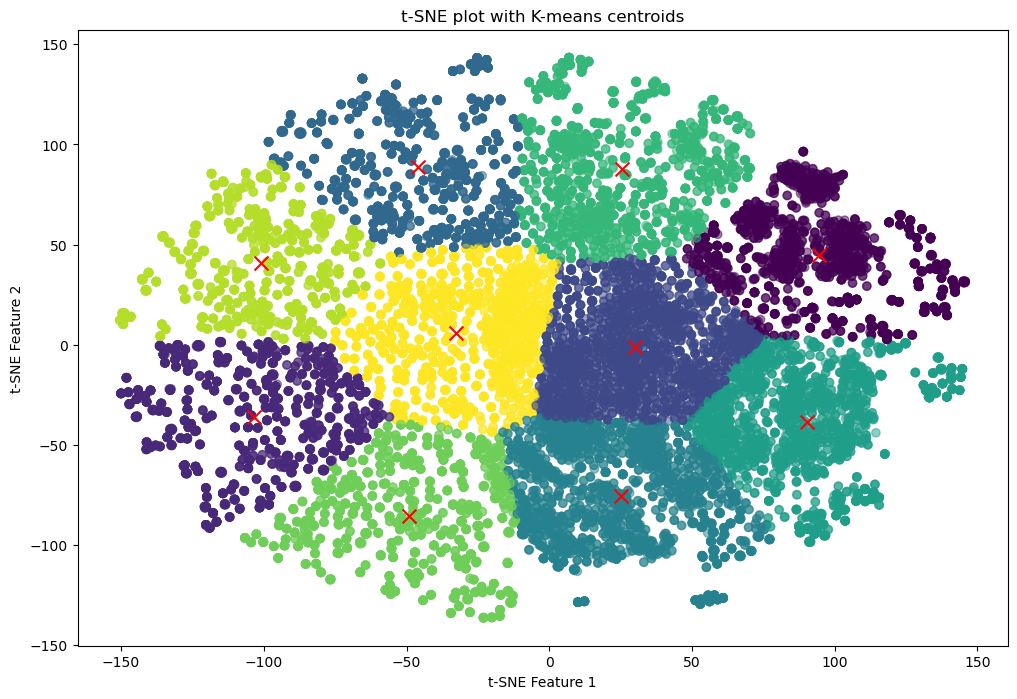

In [74]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'tsne' is the result of your t-SNE dimensionality reduction
# and 'balanced_dataset_x' is your original dataset before reduction

# Perform K-means clustering on the t-SNE reduced data
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42, n_init=10)
kmeans.fit(tsne)
kmeans_centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Now you can plot the t-SNE 2D scatter plot with the cluster assignments and centroids
plt.figure(figsize=(12, 8))
plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster_labels, alpha=0.5, cmap='viridis')

# Plot the centroids as red crosses
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', s=100, marker='x')

# Label your axes and title your plot
plt.title('t-SNE plot with K-means centroids')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')

# Show the plot
plt.show()




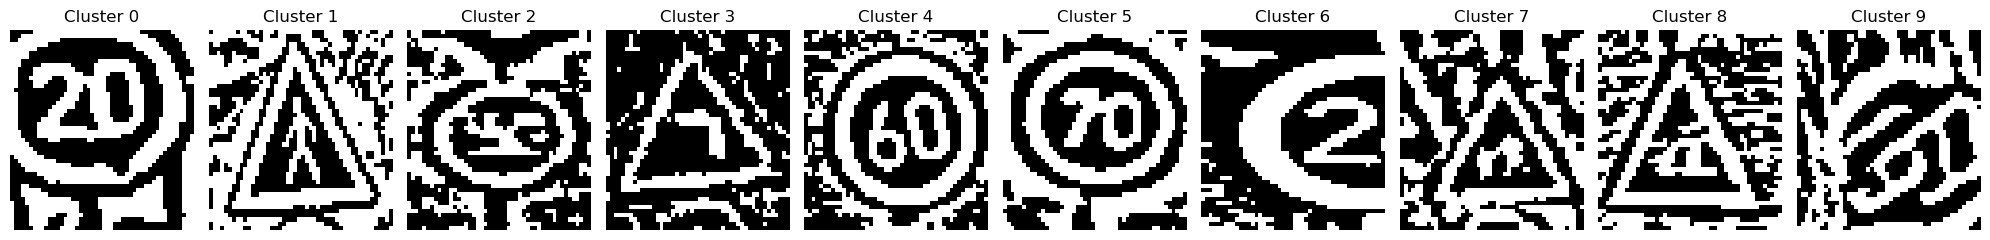

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Define the dimensions of your images
image_height = 48
image_width = 48

images_2d = balanced_dataset_x.to_numpy().reshape(-1, image_height, image_width)


fig, axs = plt.subplots(1, 10, figsize=(20, 2.5))
for i in range(10):
    # Get indices of all images in cluster i
    cluster_indices = np.where(cluster_labels == i)[0]

    if len(cluster_indices) > 0:
        # Select a random image from cluster i
        image_index = np.random.choice(cluster_indices)
        axs[i].imshow(images_2d[image_index], cmap='gray', aspect='auto')
        axs[i].axis('off')
        axs[i].set_title(f'Cluster {i}')
plt.tight_layout()
plt.show()


In [76]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Assume 'X' is your dataset
X = tsne  # Convert DataFrame to NumPy array if necessary

# Initialize Gaussian Mixture Model
# n_components is the number of clusters (Gaussian distributions) to fit
gmm = GaussianMixture(n_components=10, random_state=42)

# Fit the model and predict clusters (soft clustering)
gmm.fit(X)
cluster_assignments = gmm.predict(X)

# For soft clustering (probabilities), you can use predict_proba
cluster_probs = gmm.predict_proba(X)

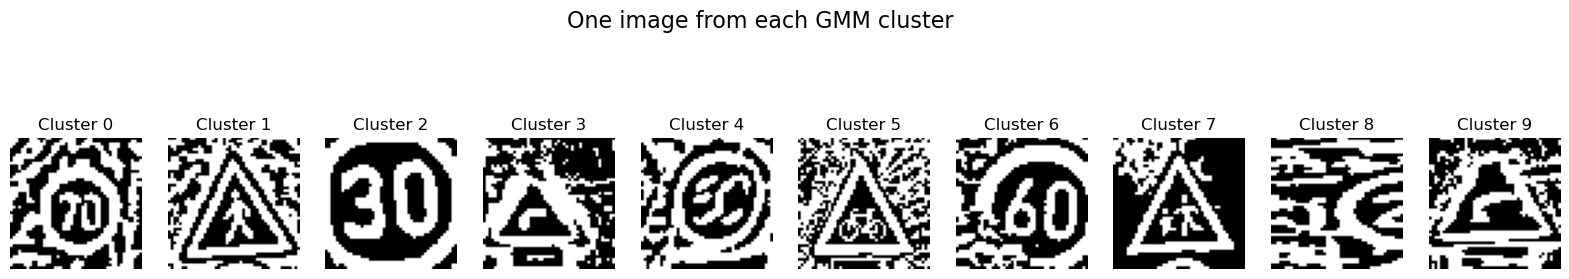

In [77]:
import matplotlib.pyplot as plt

# Assuming you know the height and width of the images
image_height = 48  # Replace with actual image height
image_width = 48   # Replace with actual image width
X= balanced_dataset_x.to_numpy()
# Reshape the dataset into the original image dimensions
images_2d = X.reshape((-1, image_height, image_width))

# Find the indices of images for each cluster
cluster_indices = {}
for cluster in range(gmm.n_components):
    cluster_indices[cluster] = np.where(cluster_assignments == cluster)[0]

# Plot one image from each cluster
fig, axs = plt.subplots(1, gmm.n_components, figsize=(20, 4))
fig.suptitle('One image from each GMM cluster', fontsize=16)

for i, indices in cluster_indices.items():
    if len(indices) > 0:  # If there are images in the cluster
        # Choose a random image index from this cluster
        image_idx = np.random.choice(indices)
        axs[i].imshow(images_2d[image_idx], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'Cluster {i}')
plt.show()
